In [1]:
from agricultural_csp.instance import *
from agricultural_csp.evaluator import *
from agricultural_csp.solver.agcsp_ts import *

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Display Function Definition and Usage

In [2]:
def display_grid_and_path(inst, evaluator, path):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
    """
    covered_nodes = evaluator.get_covered_nodes_list(path)
    
    total_nodes = inst.target_node_count
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f" - {len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(12, 10))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 0], covered_obstacles_arr[:, 1], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    if len(path) > 0:
        path_arr = np.array(path)
        plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=3, 
                label='Sprayer Path', marker='o', markersize=6, markerfacecolor='white', 
                markeredgecolor='#9900CC', markeredgewidth=2)
    
    # Plot start point (green star)
    if len(path) > 0:
        plt.scatter(path_arr[0, 0], path_arr[0, 1], c='#00DD00', s=200, 
                   marker='*', label='Start', edgecolors='black', linewidths=2, zorder=5)
    
    # Plot end point (red square)
    if len(path) > 1:
        plt.scatter(path_arr[-1, 0], path_arr[-1, 1], c='#DD0000', s=100, 
                   marker='s', label='End', edgecolors='black', linewidths=2, zorder=5)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9)
    
    title = f'Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=12, fontweight='bold')
    
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

In [3]:
center_r, center_c = 100, 100
outer_radius = 80

r_grid, c_grid = np.mgrid[0:200, 0:200]
dist_from_center = np.sqrt((r_grid - center_r)**2 + (c_grid - center_c)**2)

circle_mask = (dist_from_center <= outer_radius)
grid_nodes = np.argwhere(circle_mask)

obstacle_half_size = 5
obstacle_positions = [
    (100, 140), (130, 115), (115, 70), (70, 85), (85, 130)
]

obstacle_list = []
for obs_r, obs_c in obstacle_positions:
    mask_interna = (np.abs(r_grid - obs_r) <= obstacle_half_size) & \
                   (np.abs(c_grid - obs_c) <= obstacle_half_size)
                   
    obstacle_list.append(np.argwhere(mask_interna))

internal_obstacle_nodes = np.vstack(obstacle_list)

border_thickness = 2 

border_mask = (dist_from_center <= outer_radius) & \
              (dist_from_center >= outer_radius - border_thickness)

border_nodes = np.argwhere(border_mask)

obstacle_nodes = np.vstack([internal_obstacle_nodes, border_nodes])

obstacle_nodes = np.unique(obstacle_nodes, axis=0)

instance = AgcspInstance(grid_nodes, obstacle_nodes, 15, 90, adaptive_sampling=True) 

evaluator = AgcspEvaluator(instance)

Grid Adaptativo: Densidade original (20081)
Grid Adaptativo: Nova densidade (reduzida) (11547 nós)


Coverage: 0/18464 nodes (0.0%)
Obstacles: 0/1617 covered


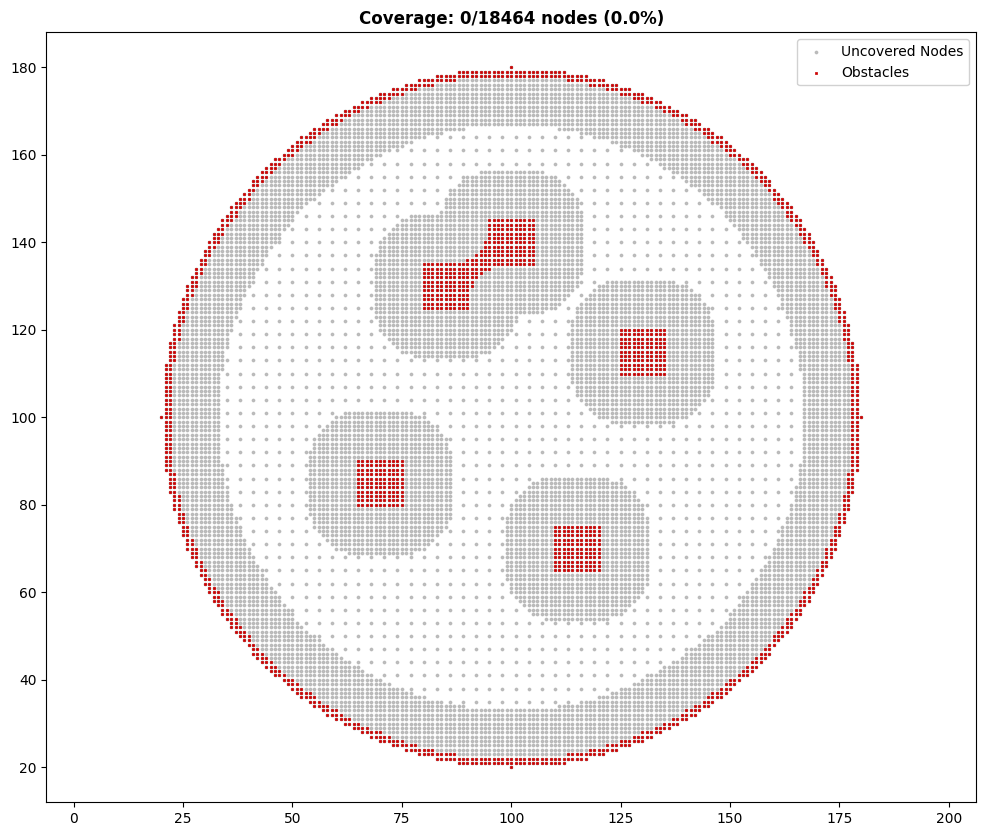

In [4]:
display_grid_and_path(inst=instance, evaluator=evaluator, path=[])

In [5]:
strategy = TSStrategy(
    constructive_heuristic=ConstructiveHeuristicType.FSM_COVERAGE_PLANNER,
    phased_optimization=PhasedOptimizationParams(phase_iterations=[5, 1, 5], degradation_tolerances=[0, 0, 0]),
    tabu_radius=3,
    search_strategy='first'
)

term_criteria = TerminationCriteria(max_iterations=50)
debug_options = DebugOptions(verbose=True)

ts = AgcspTS(instance, tenure=10, strategy=strategy, termination_criteria=term_criteria, debug_options=debug_options)

  Visitou (np.int64(30), np.int64(90)), cobriu 86 novos nós. 12891 restantes.
Heurística 'Set Cover': Iniciando. 12891 alvos restantes.
  Visitou (np.int64(37), np.int64(87)), cobriu 109 novos nós. 12782 restantes.
  Visitou (np.int64(37), np.int64(79)), cobriu 86 novos nós. 12696 restantes.
  Visitou (np.int64(37), np.int64(71)), cobriu 56 novos nós. 12640 restantes.
  Visitou (np.int64(40), np.int64(64)), cobriu 56 novos nós. 12584 restantes.
  Visitou (np.int64(44), np.int64(57)), cobriu 55 novos nós. 12529 restantes.
  Visitou (np.int64(48), np.int64(64)), cobriu 85 novos nós. 12444 restantes.
  Visitou (np.int64(56), np.int64(64)), cobriu 114 novos nós. 12330 restantes.
  Visitou (np.int64(64), np.int64(64)), cobriu 114 novos nós. 12216 restantes.
  Visitou (np.int64(72), np.int64(64)), cobriu 114 novos nós. 12102 restantes.
  Visitou (np.int64(80), np.int64(64)), cobriu 114 novos nós. 11988 restantes.
  Visitou (np.int64(88), np.int64(64)), cobriu 114 novos nós. 11874 restantes.


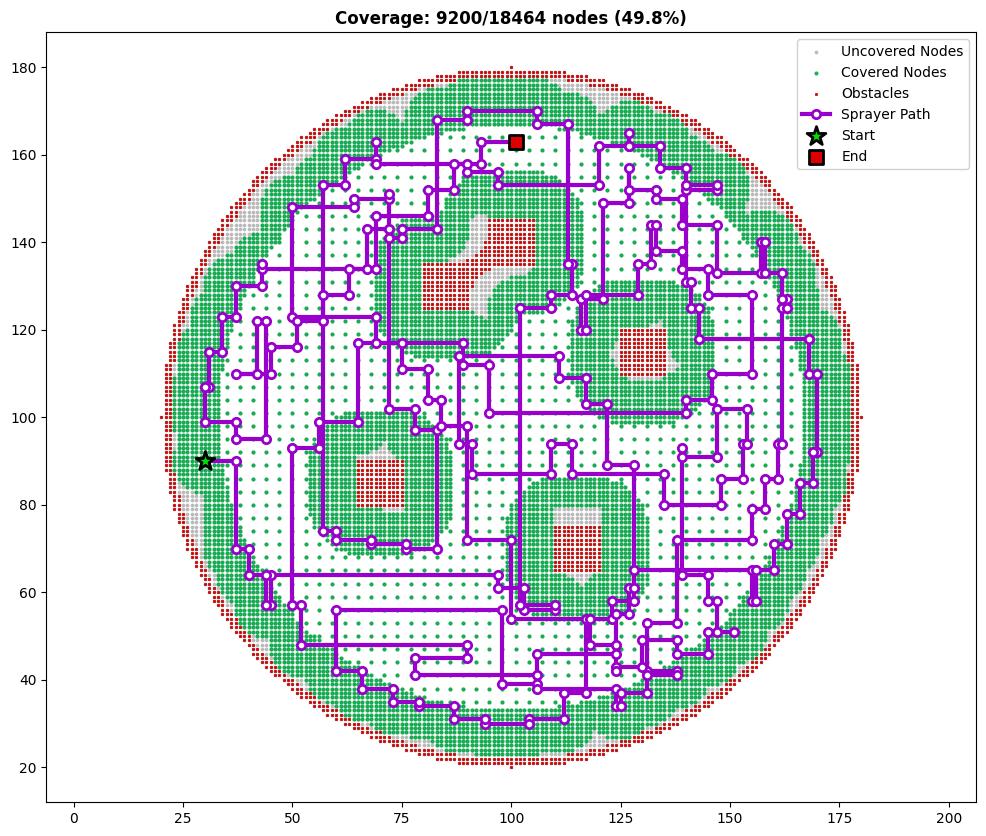

In [6]:
initial_sol = ts._constructive_heuristic(strategy.constructive_heuristic)
display_grid_and_path(instance, evaluator, initial_sol.path)

In [7]:
solution = ts.solve(initial_solution=initial_sol)

--- Iniciando TS com solução fornecida. ---
-----------------------------------------------------------
Initial solution objective value: 8693.51
-----------------------------------------------------------
Iteration 0: Best ObjFun = 8693.51, Current ObjFun = 8693.51
Applying move: remove with args (169,)
Iteration 1: Best ObjFun = 8686.33, Current ObjFun = 8686.33
Applying move: insert with args ((np.int64(92), np.int64(116)), 201)
Iteration 2: Best ObjFun = 8685.89, Current ObjFun = 8685.89
Applying move: move with args (60, array([134, 162]))
Iteration 3: Best ObjFun = 8678.18, Current ObjFun = 8678.18
Applying move: move with args (98, array([94, 30]))
Iteration 4: Best ObjFun = 8673.24, Current ObjFun = 8673.24
Applying move: move with args (39, array([68, 72]))
Iteration 5: Best ObjFun = 8667.67, Current ObjFun = 8667.67
Applying move: insert with args ((np.int64(143), np.int64(154)), 65)

=== Trocando para Fase 2 (Objetivo: Otimizar C2) ===
Iteration 6: Best ObjFun = 8666.93, Cur

# Evaluator and Cache testing

In [8]:
sol = AgcspSolution(path)
display(circular_evaluator.coverage_proportion(sol))
display(sol.cache['hits_obstacle'])
circular_evaluator.manouver_complexity_penalty(sol)

NameError: name 'path' is not defined

In [ ]:
circular_evaluator.objfun(sol)

np.float64(10730.671558929684)

# Testing neighborhood step evaluations

### a) Node Removal Step

In [ ]:
print("--- Teste do Movimento de Removal ---")

initial_sol_removal = AgcspSolution(path)
initial_cost_removal = circular_evaluator.objfun(initial_sol_removal)
print(f"Custo Inicial: {initial_cost_removal:.4f}")

node_idx_to_remove = 6
print(f"Ação: Remover o nó na posição {node_idx_to_remove}")

calculated_delta_removal = circular_evaluator.evaluate_removal_delta(initial_sol_removal, node_idx_to_remove)
print(f"Delta Calculado pelo método: {calculated_delta_removal:.4f}")

new_path_removal = np.delete(np.array(initial_sol_removal.path), node_idx_to_remove, axis=0)
new_sol_removal = AgcspSolution(new_path_removal)
new_cost_removal = circular_evaluator.objfun(new_sol_removal)
expected_delta_removal = new_cost_removal - initial_cost_removal

print(f"Custo da Nova Solução (recalculado): {new_cost_removal:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_removal:.4f}")

if np.isclose(calculated_delta_removal, expected_delta_removal):
    print("\nO método 'evaluate_removal_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")

--- Teste do Movimento de Removal ---
Custo Inicial: 10730.6716
Ação: Remover o nó na posição 6
Delta Calculado pelo método: 101.8433
Custo da Nova Solução (recalculado): 10832.5149
Delta Esperado (new_cost - old_cost): 101.8433

O método 'evaluate_removal_delta' está correto.


In [ ]:
removal_delta_components = circular_evaluator.evaluate_removal_delta(initial_sol_removal, node_idx_to_remove, return_components=True)
print(removal_delta_components)

(np.float64(106.93982885615257), np.float64(-4.8457155268812215), np.float64(-0.25078437202012516))


Coverage: 1868/18464 nodes (10.1%)
Obstacles: 0/1617 covered


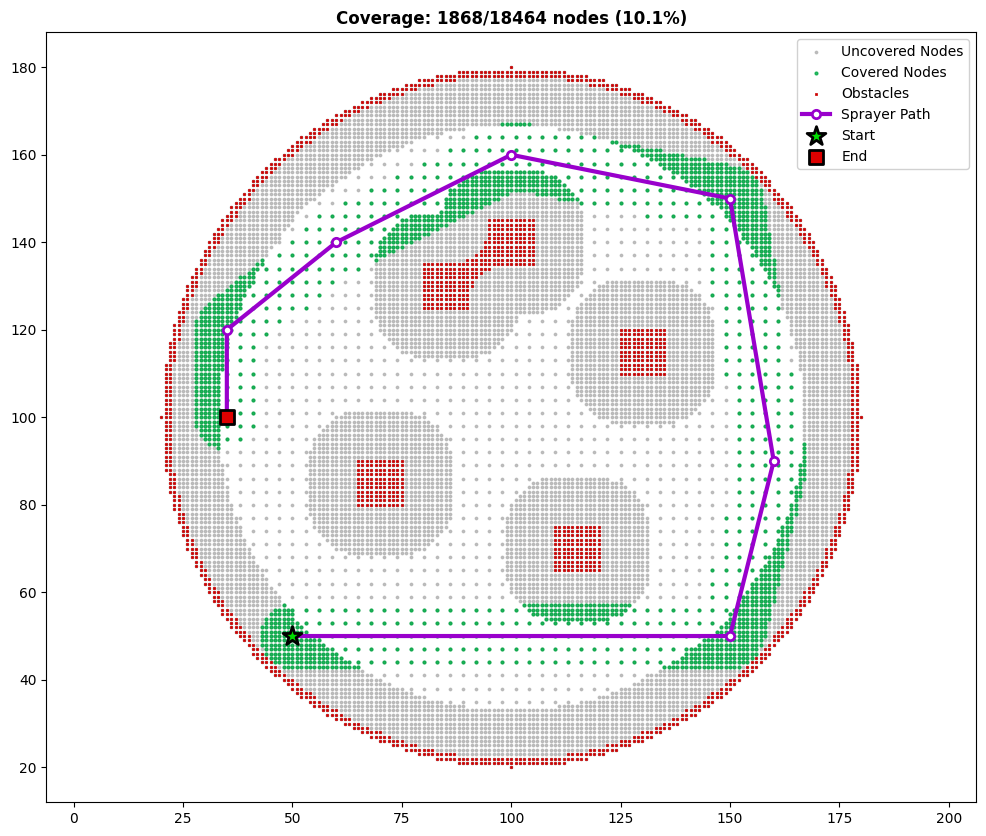

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, path)

Coverage: 1697/18464 nodes (9.2%)
Obstacles: 0/1617 covered


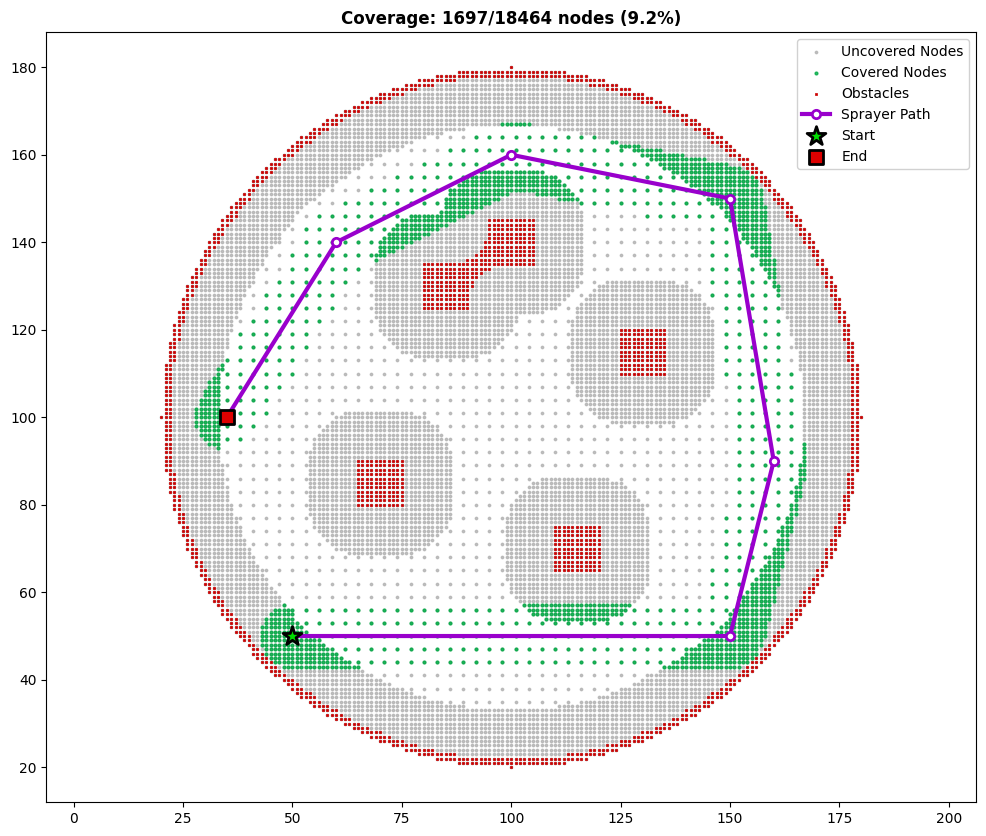

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, new_path_removal)

### b) Insertion Method

In [ ]:
print("\n--- Teste do Movimento de Insertion ---")

initial_sol_insertion = AgcspSolution(path)
initial_cost_insertion = circular_evaluator.objfun(initial_sol_insertion)
print(f"Custo Inicial: {initial_cost_insertion:.4f}")

node_to_insert = (160, 60)  # New node to insert
insert_position = 2  # Position to insert the new node
print(f"Ação: Inserir o nó {node_to_insert} na posição {insert_position}")

calculated_delta_insertion = circular_evaluator.evaluate_insertion_delta(initial_sol_insertion, node_to_insert, insert_position)
print(f"Delta Calculado pelo método: {calculated_delta_insertion:.4f}")

new_path_insertion = np.insert(np.array(initial_sol_insertion.path), insert_position, node_to_insert, axis=0)
new_sol_insertion = AgcspSolution(new_path_insertion)
new_cost_insertion = circular_evaluator.objfun(new_sol_insertion)
expected_delta_insertion = new_cost_insertion - initial_cost_insertion

print(f"Custo da Nova Solução (recalculado): {new_cost_insertion:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_insertion:.4f}")

if np.isclose(calculated_delta_insertion, expected_delta_insertion):
    print("\nO método 'evaluate_insertion_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de Insertion ---
Custo Inicial: 10730.6716
Ação: Inserir o nó (160, 60) na posição 2
Delta Calculado pelo método: inf
Custo da Nova Solução (recalculado): 10647.6647
Delta Esperado (new_cost - old_cost): -83.0069

O delta calculado é diferente do esperado.


In [ ]:
insertion_delta_components = circular_evaluator.evaluate_insertion_delta(initial_sol_insertion, node_to_insert, insert_position, return_components=True)
print(insertion_delta_components)

(inf, inf, inf)


Coverage: 1868/18464 nodes (10.1%)
Obstacles: 0/1617 covered


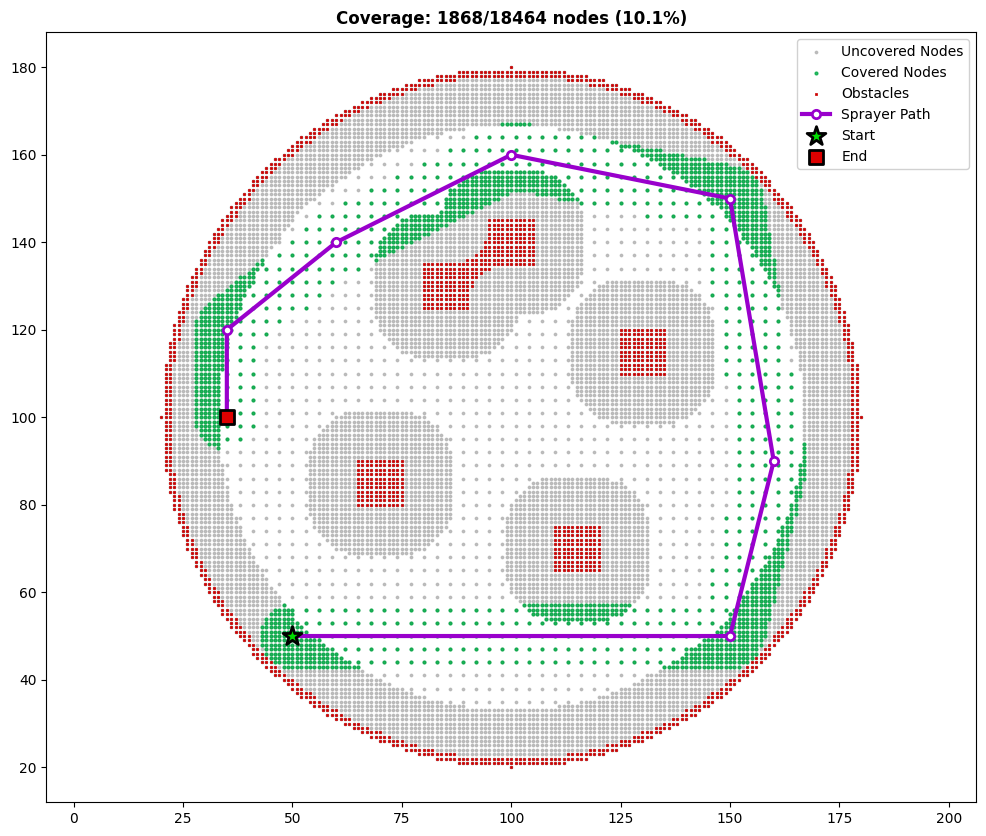

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, path)

Coverage: 1990/18464 nodes (10.8%)
Obstacles: 0/1617 covered


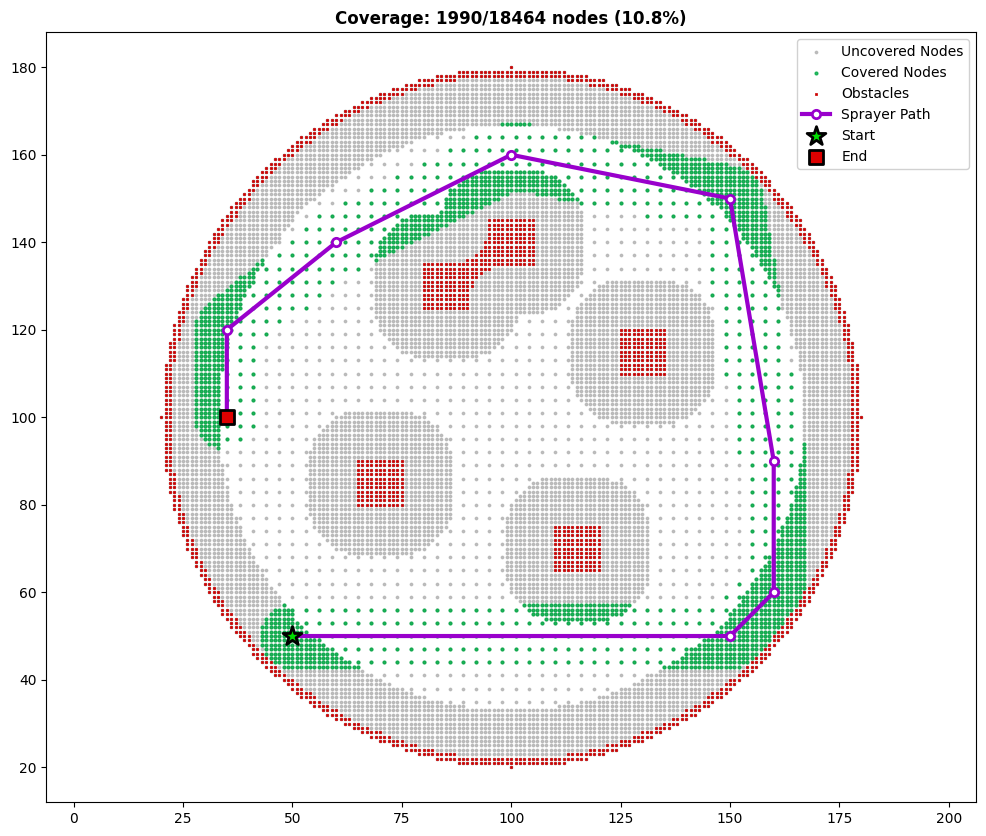

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, new_path_insertion)

### c) Node swap step

In [ ]:
print("\n--- Teste do Movimento de Swap ---")

initial_sol_swap = AgcspSolution(path)
initial_cost_swap = circular_evaluator.objfun(initial_sol_swap)
print(f"Custo Inicial: {initial_cost_swap:.4f}")

idx1, idx2 = 1, 3
print(f"Ação: Trocar os nós nas posições {idx1} e {idx2}")

calculated_delta_swap = circular_evaluator.evaluate_swap_delta(initial_sol_swap, idx1, idx2)
print(f"Delta Calculado pelo método: {calculated_delta_swap:.4f}")

new_path_swap = np.array(initial_sol_swap.path).copy()
new_path_swap[idx1], new_path_swap[idx2] = new_path_swap[idx2].copy(), new_path_swap[idx1].copy()
new_sol_swap = AgcspSolution(new_path_swap)
new_cost_swap = circular_evaluator.objfun(new_sol_swap)
expected_delta_swap = new_cost_swap - initial_cost_swap

print(f"Custo da Nova Solução (recalculado): {new_cost_swap:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_swap:.4f}")

if np.isclose(calculated_delta_swap, expected_delta_swap):
    print("\nO método 'evaluate_swap_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de Swap ---
Custo Inicial: 10730.6716
Ação: Trocar os nós nas posições 1 e 3
Delta Calculado pelo método: inf
Custo da Nova Solução (recalculado): 10169.3113
Delta Esperado (new_cost - old_cost): -561.3602

O delta calculado é diferente do esperado.


Coverage: 1868/18464 nodes (10.1%)
Obstacles: 0/1617 covered


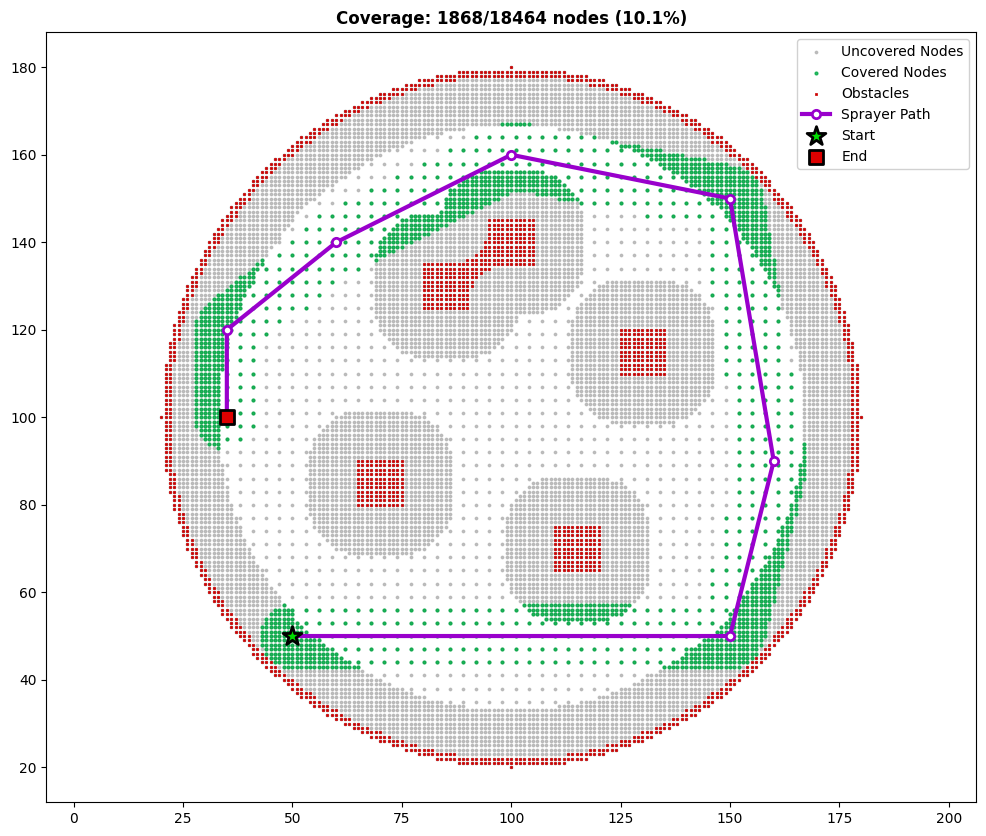

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, path)

Coverage: 2819/18464 nodes (15.3%)
Obstacles: 0/1617 covered


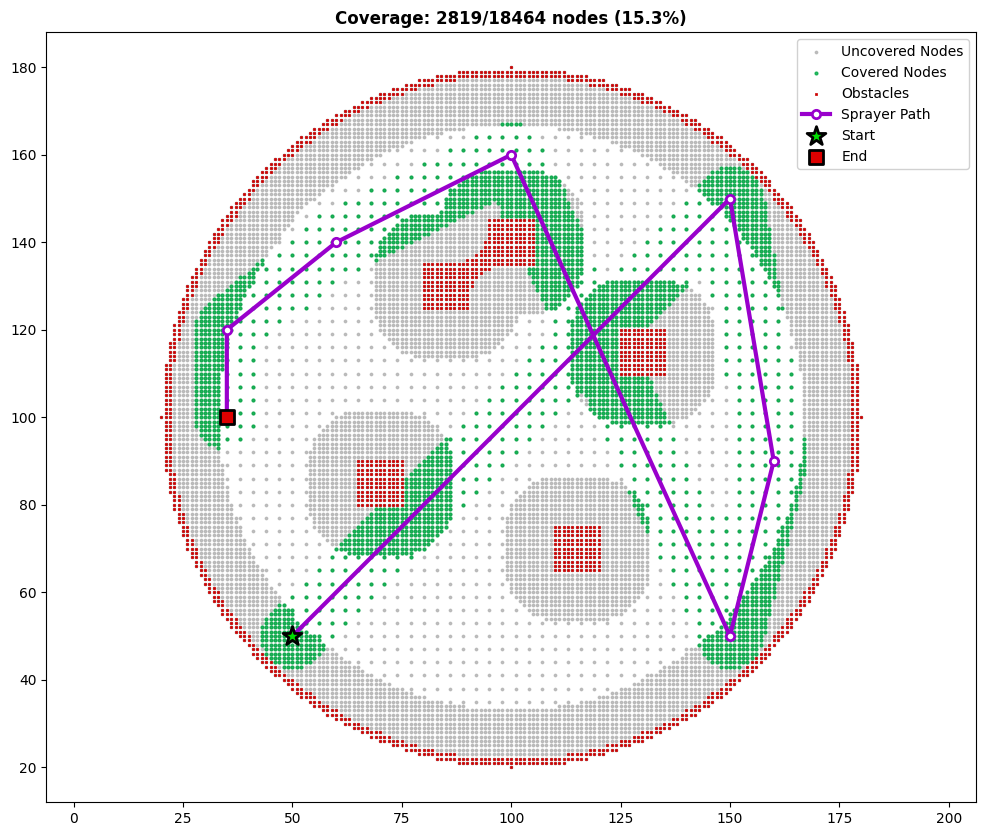

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, new_path_swap)

### d) Node move step

In [ ]:
print("\n--- Teste do Movimento de Move ---")

initial_sol_move = AgcspSolution(path)
initial_cost_move = circular_evaluator.objfun(initial_sol_move)
print(f"Custo Inicial: {initial_cost_move:.4f}")

node_idx_to_move = 0
min_distance = 10
direction = 'up'
print(f"Ação: Mover o nó na posição {node_idx_to_move} para a direção '{direction}' com distância mínima {min_distance}")

calculated_delta_move = circular_evaluator.evaluate_move_delta(initial_sol_move, node_idx_to_move, min_distance, direction)

if calculated_delta_move is None:
    print("Nenhum nó válido encontrado na direção especificada.")
elif calculated_delta_move == float('inf'):
    print("O movimento resultaria em uma solução inválida (colisão com obstáculo ou ângulo de virada inválido).")
else:
    print(f"Delta Calculado pelo método: {calculated_delta_move:.4f}")
    
    # Find the new node to verify
    new_node = circular_evaluator._find_node_in_direction(
        np.array(initial_sol_move.path[node_idx_to_move]), min_distance, direction
    )
    print(f"Nó original: {initial_sol_move.path[node_idx_to_move]}, Novo nó: {tuple(new_node)}")
    
    # Create the new path manually
    new_path_move = np.array(initial_sol_move.path).copy()
    new_path_move[node_idx_to_move] = new_node
    new_sol_move = AgcspSolution(new_path_move)
    new_cost_move = circular_evaluator.objfun(new_sol_move)
    expected_delta_move = new_cost_move - initial_cost_move
    
    print(f"Custo da Nova Solução (recalculado): {new_cost_move:.4f}")
    print(f"Delta Esperado (new_cost - old_cost): {expected_delta_move:.4f}")
    
    if np.isclose(calculated_delta_move, expected_delta_move):
        print("\nO método 'evaluate_move_delta' está correto.")
    else:
        print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de Move ---
Custo Inicial: 10730.6716
Ação: Mover o nó na posição 0 para a direção 'up' com distância mínima 10
Delta Calculado pelo método: 64.7947
Nó original: [50. 50.], Novo nó: (np.int64(59), np.int64(50))
Custo da Nova Solução (recalculado): 10795.4663
Delta Esperado (new_cost - old_cost): 64.7947

O método 'evaluate_move_delta' está correto.


In [ ]:
move_delta_components = circular_evaluator.evaluate_move_delta(initial_sol_move, node_idx_to_move, min_distance, direction, return_components=True)
print(move_delta_components)

(np.float64(73.79473570190643), np.float64(-9.0), np.float64(0.0))


Coverage: 1868/18464 nodes (10.1%)
Obstacles: 0/1617 covered


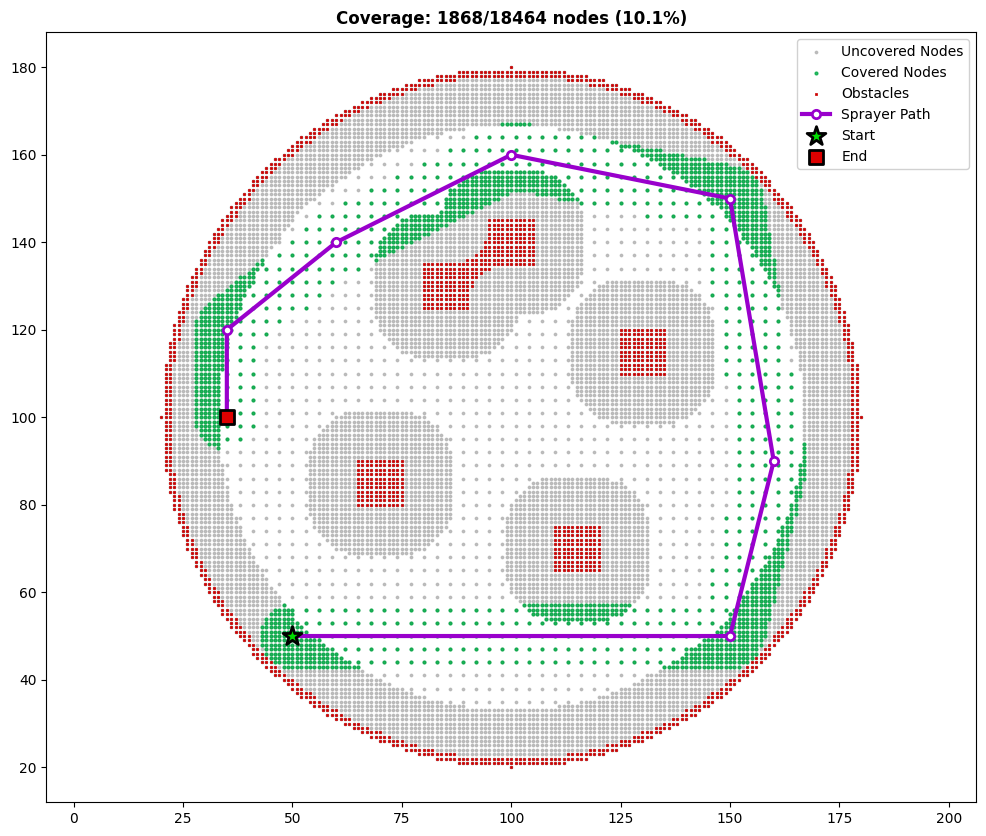

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, path)

Coverage: 1750/18464 nodes (9.5%)
Obstacles: 0/1617 covered


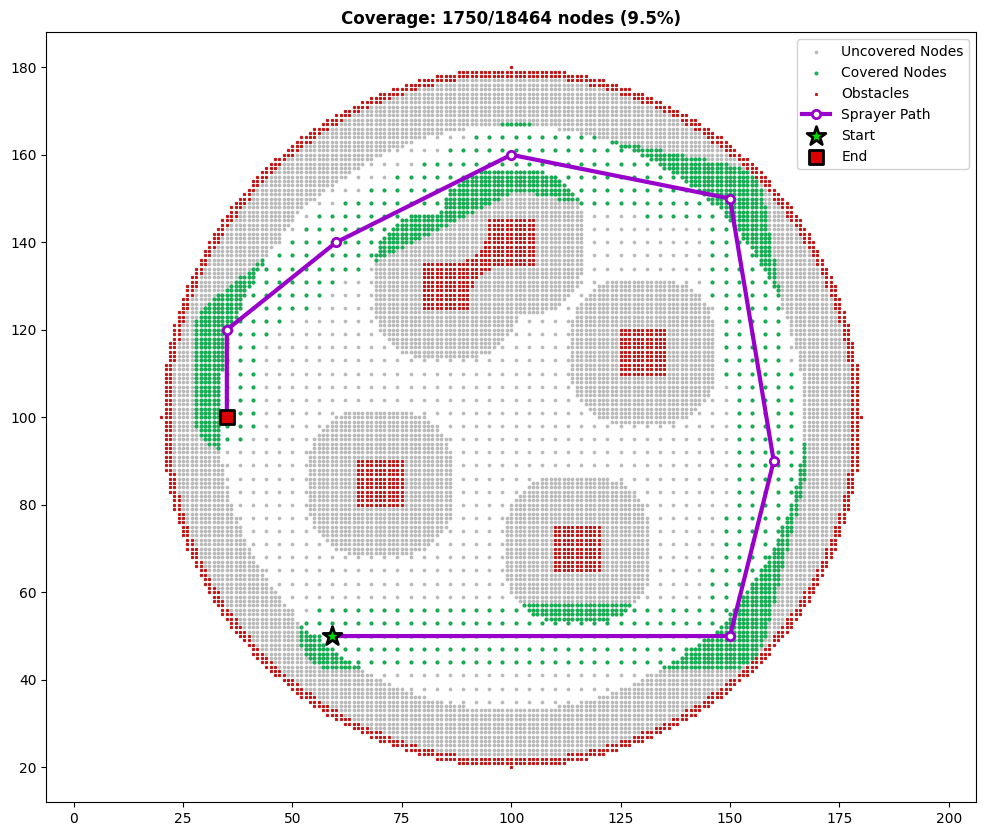

In [ ]:
if calculated_delta_move is not None and calculated_delta_move != float('inf'):
    display_grid_and_path(circular_inst, circular_evaluator, new_path_move)

# Testing Construction Heuristic

In [ ]:
from agricultural_csp.solver.agcsp_ts import *

In [ ]:
ts = AgcspTS(circular_inst)

In [ ]:
circular_inst.field_nodes

array([[113,  26],
       [118, 104],
       [ 90,  42],
       ...,
       [138,  83],
       [102, 160],
       [ 41, 150]], shape=(18464, 2))

In [ ]:
gen_sol = ts._constructive_heuristic(ConstructiveHeuristicType.BOUSTROPHEDON_SEGMENTED)

  Iniciando em (np.int64(68), np.int64(37))


Coverage: 4513/18464 nodes (24.4%)
Obstacles: 0/1617 covered


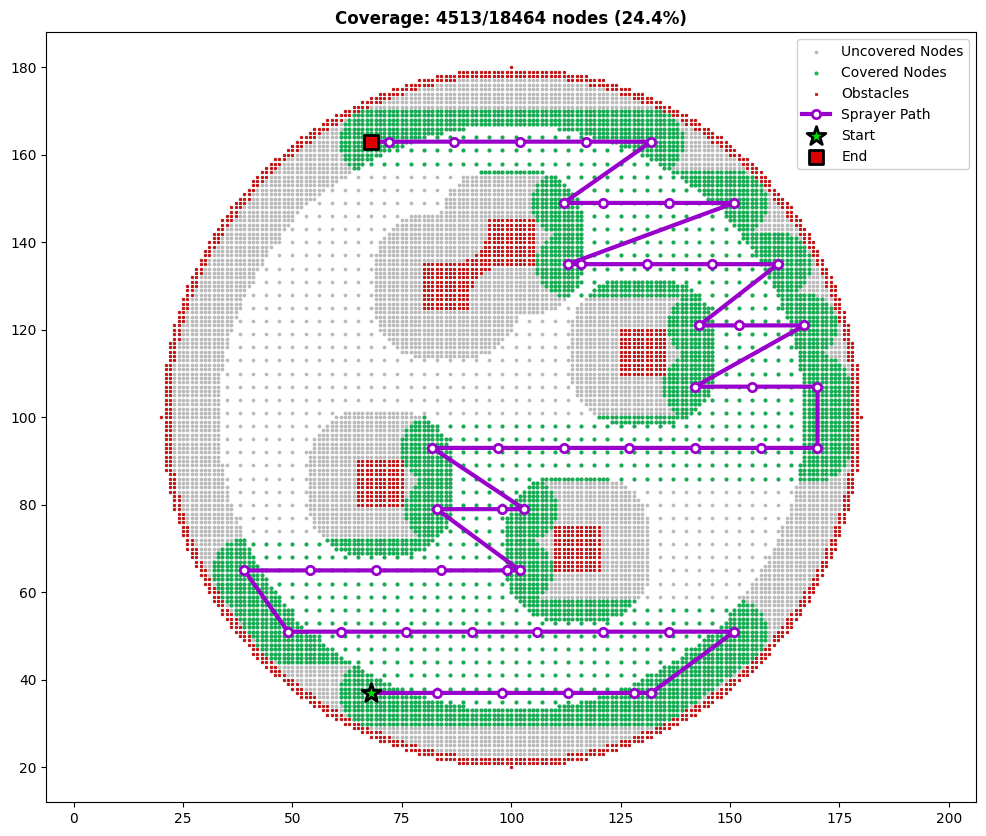

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, gen_sol.path)

In [ ]:
gen_sol = ts._constructive_heuristic(ConstructiveHeuristicType.RANDOM)

No valid uncovered nodes found. Trying covered nodes near uncovered areas...
Could not find any valid node to add from 11546 candidates.


Coverage: 0/18464 nodes (0.0%)
Obstacles: 0/1617 covered


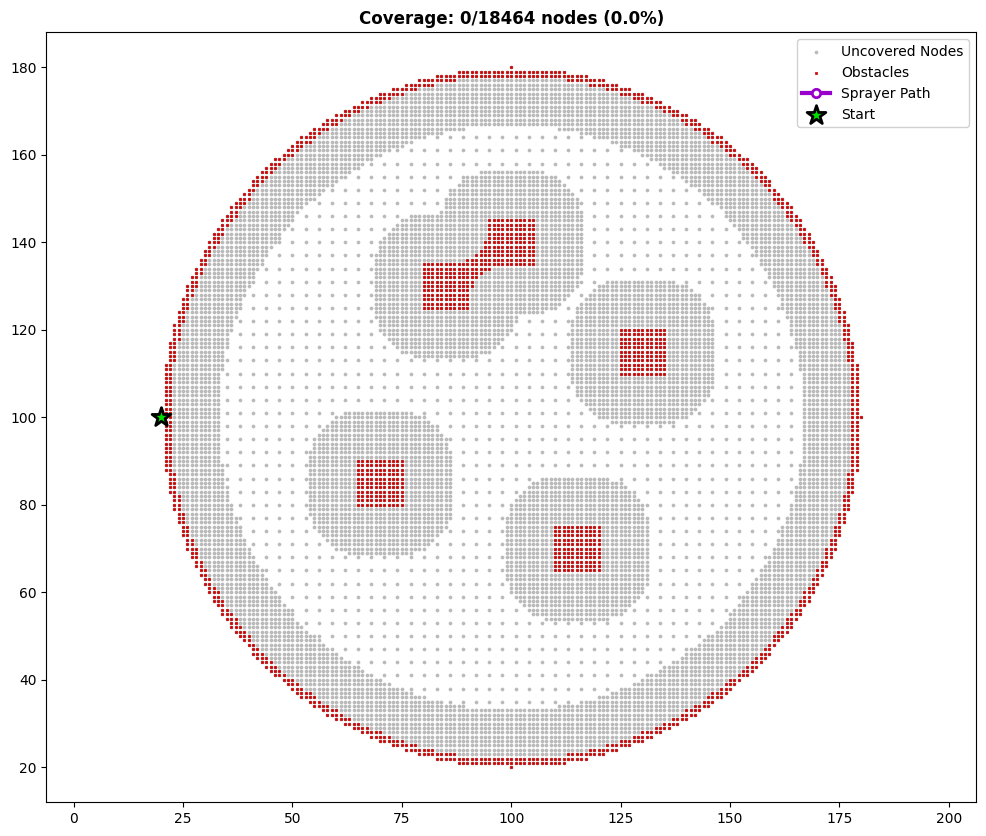

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, gen_sol.path)

In [ ]:
gen_sol = ts._constructive_heuristic(ConstructiveHeuristicType.FSM_COVERAGE_PLANNER)

  Visitou (np.int64(30), np.int64(90)), cobriu 86 novos nós. 12891 restantes.
Heurística 'Set Cover': Iniciando. 12891 alvos restantes.
  Visitou (np.int64(37), np.int64(87)), cobriu 109 novos nós. 12782 restantes.
  Visitou (np.int64(37), np.int64(79)), cobriu 86 novos nós. 12696 restantes.
  Visitou (np.int64(37), np.int64(71)), cobriu 56 novos nós. 12640 restantes.
  Visitou (np.int64(40), np.int64(64)), cobriu 56 novos nós. 12584 restantes.
  Visitou (np.int64(44), np.int64(57)), cobriu 55 novos nós. 12529 restantes.
  Visitou (np.int64(48), np.int64(64)), cobriu 85 novos nós. 12444 restantes.
  Visitou (np.int64(56), np.int64(64)), cobriu 114 novos nós. 12330 restantes.
  Visitou (np.int64(64), np.int64(64)), cobriu 114 novos nós. 12216 restantes.
  Visitou (np.int64(72), np.int64(64)), cobriu 114 novos nós. 12102 restantes.
  Visitou (np.int64(80), np.int64(64)), cobriu 114 novos nós. 11988 restantes.
  Visitou (np.int64(88), np.int64(64)), cobriu 114 novos nós. 11874 restantes.


Coverage: 9200/18464 nodes (49.8%)
Obstacles: 0/1617 covered


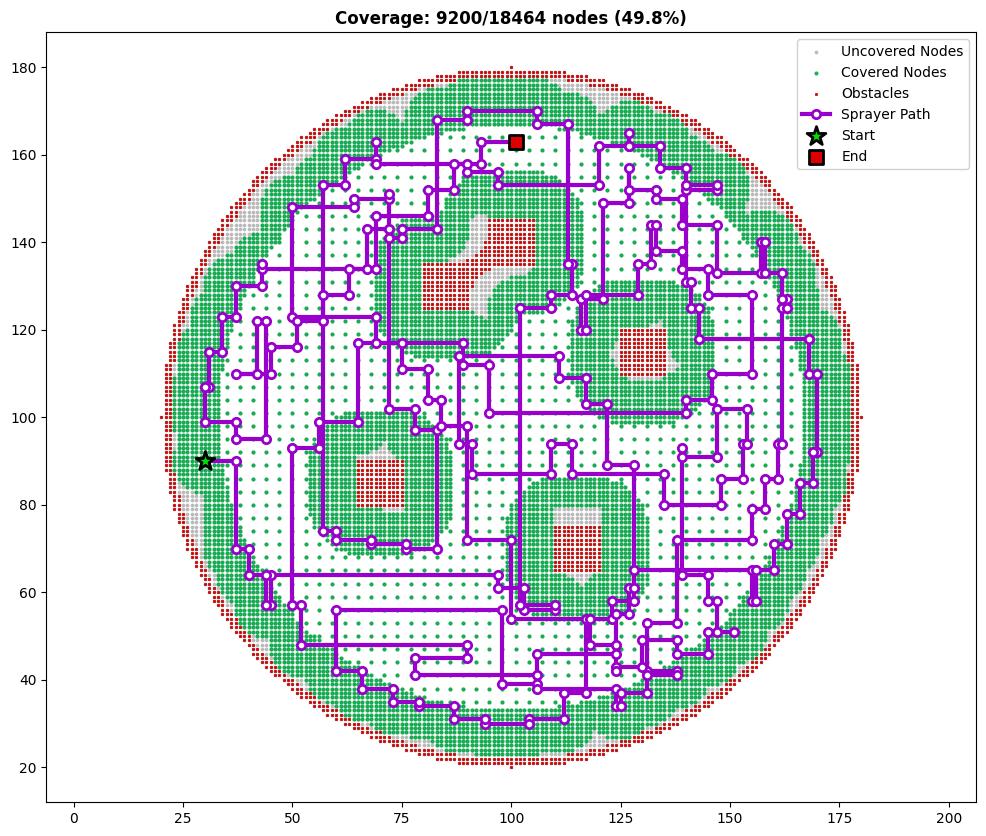

In [ ]:
display_grid_and_path(circular_inst, circular_evaluator, gen_sol.path)